# Evaluation of Fragmentation


##### Statistics of Interest
- Share of NS/Domains doing fragmentation
- CDF of min MTU values over the NS/Domains

##### Procedure
- load CSV
- transform CSV into pseudo-df
- load pseudo-df to actual df
- filter and trasform to obtain statistics
- plot statistics


In [1]:
import csv
import json
import pandas as pd
import matplotlib as plt
import seaborn as sb
import numpy as np

pd.options.plotting.backend = 'matplotlib'
plt.style.use('ggplot')


REPO_DIR = '../../dnssec-downgrade-data/'
DATA_DIR = REPO_DIR + '/2021-10-01_pmtud-frag-ns/'  # location of input/raw and processed data
STATS_DIR = DATA_DIR + '/stats/' # output location fo tables and plots 

CSV_DATA_FILENAME = DATA_DIR + "/pmtud_all_2021-10-01.csv"
RAW_RESPONSES_DF_PICKLE = DATA_DIR + "/raw_responses_df.pickle.gz"

TOP100K_FILENAME = DATA_DIR + '/top-100k.csv'  # Tranco Top100k from early June
# TOP100K_FILENAME = DATA_DIR + '/top-1m.csv'  # Tranco Top1M from early June
TLDS_FILENAME =  DATA_DIR +'/tlds-enum.csv'  # IANA List of TLDs from early June

DESIRED_POPULATION = "domain"
DESIRED_POPULATION_COMPLEMENT = "ns_ip"
# DESIRED_POPULATION = "ns_ip"
# DESIRED_POPULATION_COMPLEMENT = "domain"

## Load Raw Data

### Load Domain Lists
for selection of subsets of the response data

In [2]:
df_tlds = pd.read_csv(TLDS_FILENAME, sep=",", names=['rank', 'domain'], index_col=0)  # "rank" is alphabetical
df_top100k = pd.read_csv(TOP100K_FILENAME, sep=",", names=['rank', 'domain'], index_col=0)  # rank is Tranco Rank

df_top100k

,domain
rank,
1,google.com
2,youtube.com
3,facebook.com
4,microsoft.com
5,netflix.com
...,...
99996,santamonicapier.org
99997,gourmetads.com
99998,guazi.com


#### CSV-Format for NS Response Data
NS-IP, DOMAIN, RESPONSE_STATUS, Response1, Response2, Response3, Response4, Response5

```
Response/MTU Test Semantics:
Response1: without preceeding ICMP (equals 1500 in most cases, probably; which is MTU of Ethernet)
Response2: 1280
Response3:  576
Response4:  296
Response5:   68
```

Note: If the first message ERRs, no second is sent. Presence of a response descriptor is optional. A response does not necessarily respect the MTU from the ICMP message and can thus carry any fragment size (or none at all).

##### Cell Format of Responses
dX_mY_IPlen_UDPlen_tZ

```
dX     -> whether DF was set (X=1) or unset (X=0)
mY     -> whether MF was set (Y=1) or unset (Y=0); if Y=1 MTU conforms to IPlen
IPlen  -> length of the IP fragment/packet received
UDPlen -> length of the UDP datagram received
tZ     -> whether response was truncated (Z=1) or not (Z=0)
```

Note: A length/flag indicator of "-1" marks a timeout. That does not imply "ERR" status, though.

##### Response Status
Any of {ERR, NDF, YDF}

```
ERR -> some kind of error; no responses present, then
NDF -> DF unset encountered in at least one of the responses?
YDF -> DF encountered in at least one of the responses
```

Takeaway: Don't trust NDF/YDF, but do parse the response specifiers.

In [3]:
KEY_IP_ADDR = "ns_ip"
KEY_DOMAIN = "domain"
KEY_STATUS = "status"
KEY_IP_DF  = "df"
KEY_DOES_FRAGMENT = "does_fragment"  # any response has m1
KEY_MIN_MTU = "min_mtu" # minimum IP packet length of the m1 response of a (NS, DOMAIN) pair

# Row indices of values of interest
I_IP = 0
I_DOM = 1
I_STAT = 2
I_R1 = 3
I_R2 = 4
I_R3 = 5
I_R4 = 6
I_R5 = 7

# Split indices of values of interest within a response specification
I_DF = 0
I_MF = 1
I_IPLEN = 2
I_UDPLEN = 3
I_TC = 4

# Constants to compare values from response specification against
V_DF_TRUE = 'd1'  # d-1 is timeout case; do check for V_DF_FALSE explicitly (i.e. not for V_DF_TRUE mismatch)
V_DF_FALSE = 'd0'
V_MF_TRUE = 'm1'  # m-1 is timeout case
V_MF_FALSE = 'm0'
V_TC_TRUE = 't1'  # we check only for fragmentation behavior, so we can include these responses
V_TC_FALSE = 't0'

response_data = []

def read_response_csv(csv_filename=CSV_DATA_FILENAME):
    with open(csv_filename, 'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        for row in csv_reader:
            dat = dict()
            dat[KEY_IP_ADDR] = row[I_IP]
            dat[KEY_DOMAIN] = row[I_DOM]
            dat[KEY_STATUS] = row[I_STAT]
            # if status != "ERR":  # ignored...
        
            min_iplen = 2**16
            does_fragment = False
            for i_ri in range(I_R1, I_R5+1):
                r_splits = row[i_ri].split("_")
                if len(r_splits) > 1:
                    assert len(r_splits) == 5
                    v_df = r_splits[I_DF]
                    v_mf = r_splits[I_MF]
                    v_iplen = int(r_splits[I_IPLEN])
                    v_udplen = r_splits[I_UDPLEN]
                    v_tc = r_splits[I_TC]
                    if v_df == V_DF_FALSE and v_mf == V_MF_TRUE and (not does_fragment or v_iplen < min_iplen):
                        does_fragment = True
                        min_iplen = v_iplen

            dat[KEY_DOES_FRAGMENT] = does_fragment
            dat[KEY_MIN_MTU] = min_iplen
            response_data.append(dat)
    return response_data
        
   

In [4]:

try:
    df_raw = pd.read_pickle(RAW_RESPONSES_DF_PICKLE, compression='gzip')
except:
    print("Parsing new Response Data from CSV")
    df_raw = pd.DataFrame(read_response_csv(CSV_DATA_FILENAME))
    df_raw.to_pickle(RAW_RESPONSES_DF_PICKLE, compression='gzip')

df_raw

,ns_ip,domain,status,does_fragment,min_mtu
0,188.244.99.132,loli.net,NDF,False,65536
1,205.251.196.183,myconnectwise.net,NDF,False,65536
2,205.251.196.129,diariodocentrodomundo.com.br,NDF,False,65536
3,204.74.115.1,sonicwall.com,YDF,False,65536
4,205.251.196.204,thedigestweb.com,NDF,False,65536
...,...,...,...,...,...
470480,202.205.177.4,cee.edu.cn,ERR,False,65536
470481,61.151.180.44,ruiwen.com,ERR,False,65536
470482,223.166.151.13,shangxueba.com,ERR,False,65536
470483,58.247.212.36,szfw.org,ERR,False,65536


In [5]:
df_top100k_raw = df_raw[df_raw['domain'].isin(df_top100k['domain'])]
print(f"Unique Top100k domains in Responses: {df_top100k_raw['domain'].nunique()}")
print(f"Unique Top100k domains: {df_top100k['domain'].nunique()}")
df_top100k_raw

Unique Top100k domains in Responses: 98377
Unique Top100k domains: 100000


,ns_ip,domain,status,does_fragment,min_mtu
0,188.244.99.132,loli.net,NDF,False,65536
1,205.251.196.183,myconnectwise.net,NDF,False,65536
2,205.251.196.129,diariodocentrodomundo.com.br,NDF,False,65536
3,204.74.115.1,sonicwall.com,YDF,False,65536
4,205.251.196.204,thedigestweb.com,NDF,False,65536
...,...,...,...,...,...
470480,202.205.177.4,cee.edu.cn,ERR,False,65536
470481,61.151.180.44,ruiwen.com,ERR,False,65536
470482,223.166.151.13,shangxueba.com,ERR,False,65536
470483,58.247.212.36,szfw.org,ERR,False,65536


In [6]:
df_tlds_raw = df_raw[df_raw['domain'].isin(df_tlds['domain'])]
print(f"Unique TLDs domains in Responses: {df_tlds_raw['domain'].nunique()}")
print(f"Unique TLDs domains: {df_tlds['domain'].nunique()}")
df_tlds_raw

Unique TLDs domains in Responses: 1496
Unique TLDs domains: 1498


,ns_ip,domain,status,does_fragment,min_mtu
23,156.154.144.6,aig,YDF,False,65536
99,37.209.198.7,academy,NDF,True,1500
105,37.209.194.7,xn--unup4y,NDF,True,1500
150,161.232.12.53,insure,NDF,False,65536
270,203.83.159.1,kr,NDF,False,65536
...,...,...,...,...,...
469403,65.22.21.51,solar,NDF,False,65536
469706,42.62.2.16,xn--30rr7y,NDF,False,65536
469936,212.1.66.247,xn--j1amh,ERR,False,65536
470002,180.149.98.234,xn--l1acc,ERR,False,65536


## Determine Desired Statistics
- share of NSs/Domains that fragment
- CDF of min_mtus over the NSs/Domains that do fragment

In [7]:
df_top100k_filtered = df_top100k_raw[df_top100k_raw['status'] != 'ERR'][[DESIRED_POPULATION, 'does_fragment', 'min_mtu']]
df_top100k_filtered = df_top100k_filtered.groupby(DESIRED_POPULATION).agg({"does_fragment": any, "min_mtu": min})
df_top100k_filtered

,does_fragment,min_mtu
domain,,
00-tv.com,False,65536
000space.com,False,65536
000webhost.com,False,65536
000webhostapp.com,False,65536
000zhibo.com,False,65536
...,...,...
zzounds.com,False,65536
zztuku.com,False,65536
zzu.edu.cn,False,65536


In [8]:
df_top100k_fragmentors = df_top100k_filtered[df_top100k_filtered['does_fragment']]
df_top100k_non_fragmentors = df_top100k_filtered[~df_top100k_filtered['does_fragment']]

total_count_top100k = df_top100k_filtered.shape[0]
fragmentors_count_top100k = df_top100k_fragmentors.shape[0]
fragmentors_share_top100k = fragmentors_count_top100k / total_count_top100k
non_fragmentors_count_top100k = df_top100k_non_fragmentors.shape[0]
non_fragmentors_share_top100k = non_fragmentors_count_top100k / total_count_top100k
assert total_count_top100k == fragmentors_count_top100k + non_fragmentors_count_top100k

print(f"Fragmentors: {fragmentors_count_top100k} ({fragmentors_share_top100k})")
print(f"Non-Fragmentors: {non_fragmentors_count_top100k} ({non_fragmentors_share_top100k})")

Fragmentors: 3534 (0.036311328024659646)
Non-Fragmentors: 93791 (0.9636886719753404)


In [9]:
df_top100k_mtus_abs = df_top100k_fragmentors[['min_mtu']].reset_index().groupby('min_mtu').count()
df_top100k_mtus_abs

,domain
min_mtu,
68,77
84,1
124,5
128,2
292,99
492,1
508,2
540,2
548,1782


In [10]:
df_top100k_mtus_rel = df_top100k_mtus_abs.copy()
df_top100k_mtus_rel[DESIRED_POPULATION] = df_top100k_mtus_rel[DESIRED_POPULATION]/sum(df_top100k_mtus_rel[DESIRED_POPULATION])
df_top100k_mtus_rel

,domain
min_mtu,
68,0.021788
84,0.000283
124,0.001415
128,0.000566
292,0.028014
492,0.000283
508,0.000566
540,0.000566
548,0.504244


In [11]:
df_top100k_mtus_cdf = df_top100k_mtus_rel.copy()
df_top100k_mtus_cdf[DESIRED_POPULATION] = df_top100k_mtus_cdf[DESIRED_POPULATION].cumsum()
df_top100k_mtus_cdf

,domain
min_mtu,
68,0.021788
84,0.022071
124,0.023486
128,0.024052
292,0.052066
492,0.052349
508,0.052915
540,0.053480
548,0.557725


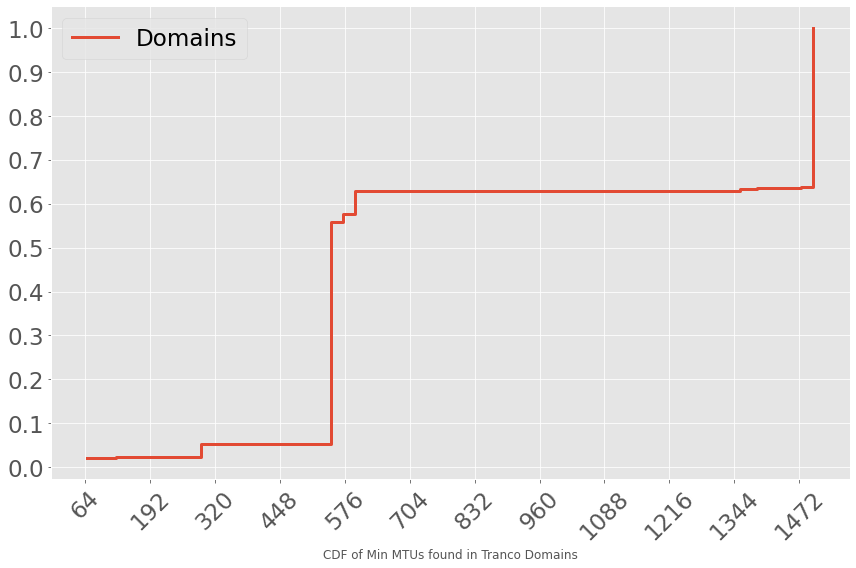

In [12]:
# xticks = [68, 296, 576, 768, 1024, 1280, 1500]
xticks = [64 + (2*x*64) for x in range(0, 12)]
yticks = [0.1 * x for x in range(0, 11)]
# xticks = [64 * x for x in range(1, 26)]

df_top100k_mtus_cdf_plt = df_top100k_mtus_cdf.plot.line(drawstyle='steps-post', subplots=False, sharex=True, xticks=xticks, yticks=yticks, sharey=True, fontsize=23, linewidth=3, figsize=(12,8))
# df_mtus_cdf_plt.set_xticklabels(df_mtus_cdf_plt.get_xticklabels(), rotation = 45, ha="right")
df_top100k_mtus_cdf_plt.legend(loc=2, prop={'size': 23}, labels=["Domains"])
for xticklabel in df_top100k_mtus_cdf_plt.get_xticklabels():
    xticklabel.set_rotation(45)
df_top100k_mtus_cdf_plt.get_figure().tight_layout()
df_top100k_mtus_cdf_plt.set_xlabel("CDF of Min MTUs found in Tranco Domains")

df_top100k_mtus_cdf_plt.get_figure().savefig(STATS_DIR+'/df_top100k_mtus_cdf_plt.pdf', format='pdf')
caption = f"Absolute numbers of Tranco domains with NS that can be forced to fragment responses down to minimum MTU. Total Fragmentors: ${fragmentors_count_top100k}$ (${fragmentors_share_top100k}$ of investigated ${total_count_top100k}$)."
df_top100k_mtus_abs.to_latex(buf=STATS_DIR+'/df_top100k_mtus_abs.tex', float_format='{:.2%}'.format, caption=caption, header=['Domains'])